# Hugging Face with Object Detection
https://huggingface.co/docs/transformers/tasks/object_detection

In [30]:
# pip install datasets[vision], transformers, albumentations

https://huggingface.co/datasets/cppe-5

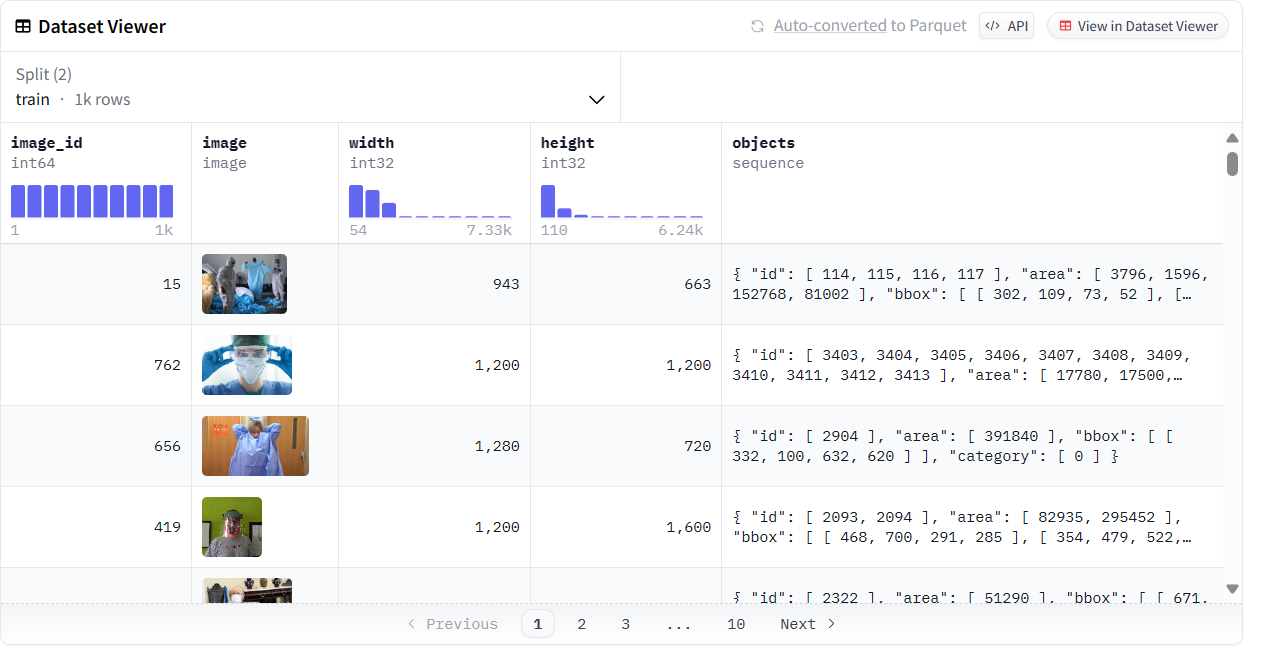

In [31]:
from huggingface_hub import notebook_login

notebook_login()

In [32]:
from datasets import load_dataset

cppe5 = load_dataset("cppe-5")

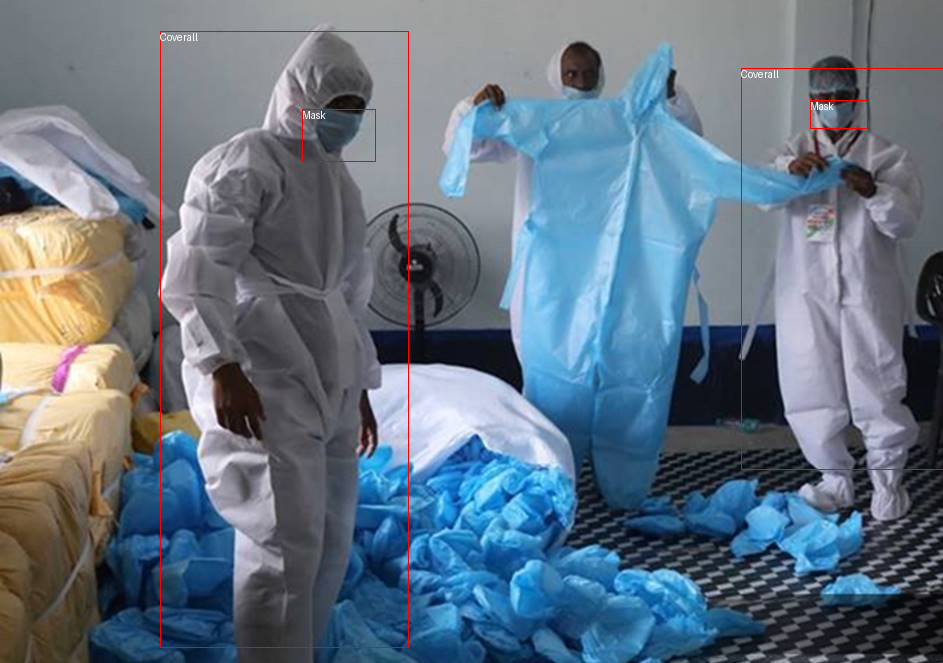

In [33]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe5["train"][0]["image"]
annotations = cppe5["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = cppe5["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    # Check if coordinates are normalized or not
    if max(box) > 1.0:
        # Coordinates are un-normalized, no need to re-scale them
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + w), int(y + h)
    else:
        # Coordinates are normalized, re-scale them
        x1 = int(x * width)
        y1 = int(y * height)
        x2 = int((x + w) * width)
        y2 = int((y + h) * height)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [34]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe5["train"])) if i not in remove_idx]
cppe5["train"] = cppe5["train"].select(keep)

In [35]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [36]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [37]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [38]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [39]:
cppe5["train"] = cppe5["train"].with_transform(transform_aug_ann)
cppe5["train"][15]

{'pixel_values': tensor([[[ 1.4440,  1.4440,  1.4440,  ..., -1.5870, -1.5870, -1.5870],
          [ 1.4440,  1.4440,  1.4440,  ..., -1.5870, -1.5870, -1.5870],
          [ 1.4440,  1.4440,  1.4440,  ..., -1.5699, -1.5699, -1.5699],
          ...,
          [-1.1589, -1.1589, -1.1589,  ..., -1.6042, -1.6042, -1.6042],
          [-1.1418, -1.1418, -1.1418,  ..., -1.6042, -1.5870, -1.5870],
          [-1.1418, -1.1418, -1.1418,  ..., -1.6042, -1.5870, -1.5870]],
 
         [[ 1.8683,  1.8683,  1.8683,  ..., -1.4405, -1.4405, -1.4405],
          [ 1.8683,  1.8683,  1.8683,  ..., -1.4405, -1.4405, -1.4405],
          [ 1.8683,  1.8683,  1.8683,  ..., -1.4230, -1.4230, -1.4230],
          ...,
          [-0.8803, -0.8803, -0.8803,  ..., -1.4580, -1.4580, -1.4580],
          [-0.8627, -0.8627, -0.8627,  ..., -1.4580, -1.4405, -1.4405],
          [-0.8627, -0.8627, -0.8627,  ..., -1.4580, -1.4405, -1.4405]],
 
         [[ 1.9777,  1.9777,  1.9777,  ..., -1.2467, -1.2467, -1.2467],
          [ 

In [40]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [41]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [43]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
)

In [44]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe5["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
50,3.442200
100,2.756300


In [ ]:
# trainer.push_to_hub()